In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import polars as ps
import pandas as pd
import scipy as sp
import json

In [2]:
def modelo_2rc(t, v0, v1, v2, t1, t2):
    return v0+v1*np.exp(-t*t1)+v2*np.exp(-t*t2)

In [3]:
def get_t_v(p1, df):
    p1, p2 = p1, p1+200
    corrente = df['Corrente [A]'][p1-1]
    v_zp1 = df['Tensão [V]'][p1-1]
    df_teste = df[p1:p2][['Tempo [s]', 'Tensão [V]']].clone()
    df_teste = df_teste.select([ps.col('Tempo [s]').alias('t'), ps.col('Tensão [V]').alias('v')])

    vmin = df_teste['v'].min()
    vmax = df_teste['v'].max()
    t0 = df_teste['t'][0]
    df_teste['t'] = df_teste['t']-df_teste['t'][0]
    df_teste['v'] = df_teste['v']-df_teste['v'][0]

    t = df_teste['t'].to_numpy()
    v = df_teste['v'].to_numpy()
    return t, v, corrente, vmin, vmax, v_zp1, t0

In [4]:
def gerar_coeficientes_e_graficos(points, I ,bounds, coeficientes, p0):
    coeficientes[I] = dict()
    for i, p1 in enumerate(points[I]):
        t, v, corrente, vmin, vmax, v_r0, t0 = get_t_v(p1, df_c100)

        # Faz o fitting da curva
        vals, cov = sp.optimize.curve_fit(f=modelo_2rc,
                                            xdata=t,
                                            ydata=v,
                                            p0=p0,
                                            maxfev=30000,
                                            bounds=bounds)
        p0 = vals+np.random.normal(0, 0.001, 5) # usa os valores atuais como o chute inicial para o próximo ponto

        v0 = vals[0]
        v1 = vals[1]
        v2 = vals[2]
        tau1 = 1/vals[3] # A otimização funciona melhor utilizando exp(t*x) ao invés de exp(t/x)
        tau2 = 1/vals[4] # A otimização funciona melhor utilizando exp(t*x) ao invés de exp(t/x)

        r0 = -(vmin-v_r0)/corrente
        r1 = v1/corrente
        r2 = v2/corrente
        c1 = tau1*corrente/v1
        c2 = tau2*corrente/v2
        coeficientes[I][f'{p1}'] = [v0, v1, v2, tau1, tau2, r0, r1, r2, c1, c2, vmin, vmax, v_r0, t0]
        
        title = f'''Curva {i}: {corrente:.0f} A
{vmax} v_max, {vmin} v_min, {vmax-vmin:.5e} ΔV
{v_r0} v_r0, {r0:.5e} r0
{v0:.3e} v0, {v1:.3e} v1, {v2:.5e} v2
{tau1:.3e} t1, {r1:.3e} r1, {c1:.3e} c1
{tau2:.3e} t2, {r2:.3e} r2, {c2:.3e} c2 
                '''
        print(title)

        plt.figure(figsize=(20, 10))
        plt.title(title,loc='left')
        sns.scatterplot(y=v, x=t, color='red')
        sns.lineplot(y=modelo_2rc(t, *vals), x=t)
        plt.grid()
        plt.show()
        plt.close()

    return coeficientes

In [5]:
WS = pd.read_excel('./Dados_C100_patricio.xlsx')
df_c100 = ps.DataFrame(WS)

# pontos iniciais
points = {
'100A':[36,   17299, 34586, 51912, 69298, 86728, 104172, 121666, 139361, 157114],
'28A' :[4483, 21738, 39026, 56352, 73738, 91168, 108612, 126106, 143801, 161554],
'3A'  :[2267, 19523, 36810, 54136, 71522, 88952, 106396, 123890, 141585, 159338]
}

# Coeficientes de cada curva
coeficientes = dict()

# chute inicial: v0, v1, v2, 1/tau1, 1/tau2
p0 = np.array([3.2247626343e-02, -2.11580237e-02, -9.80514235e-03,  3.18578442e-02, 2.12246228e-03])+np.random.normal(0, 0.001, 5)

# Limites para os valores dos coeficientes
bounds = ([-1, -100, -100, -1, -1], [100, 1, 1, np.inf, np.inf])

Curva 0: -100 A
3.343 v_max, 3.321 v_min, 2.20000e-02 ΔV
3.287 v_r0, 3.39993e-04 r0
2.179e-02 v0, -1.588e-02 v1, -5.24651e-03 v2
2.517e+01 t1, 1.588e-04 r1, 1.585e+05 c1
3.587e+02 t2, 5.246e-05 r2, 6.838e+06 c2 
                


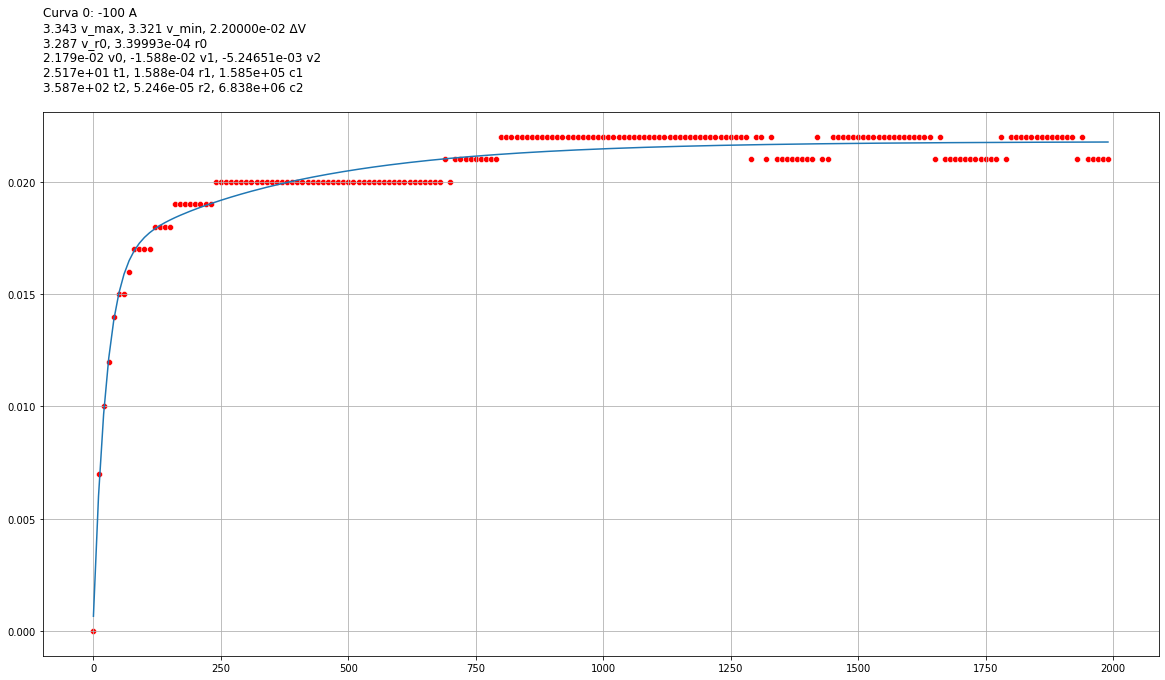

Curva 1: -100 A
3.319 v_max, 3.287 v_min, 3.20000e-02 ΔV
3.254 v_r0, 3.29993e-04 r0
3.193e-02 v0, -2.116e-02 v1, -9.80524e-03 v2
3.139e+01 t1, 2.116e-04 r1, 1.484e+05 c1
4.711e+02 t2, 9.805e-05 r2, 4.805e+06 c2 
                


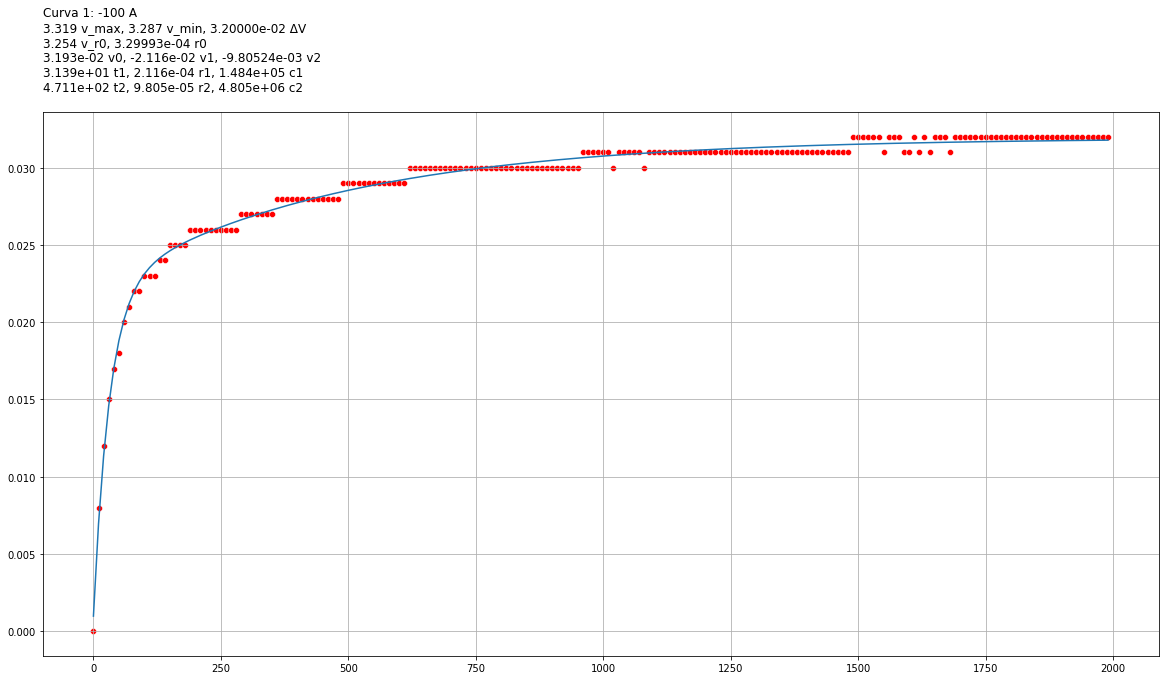

Curva 2: -100 A
3.317 v_max, 3.279 v_min, 3.80000e-02 ΔV
3.245 v_r0, 3.39993e-04 r0
3.855e-02 v0, -2.371e-02 v1, -1.25698e-02 v2
4.123e+01 t1, 2.371e-04 r1, 1.739e+05 c1
6.895e+02 t2, 1.257e-04 r2, 5.485e+06 c2 
                


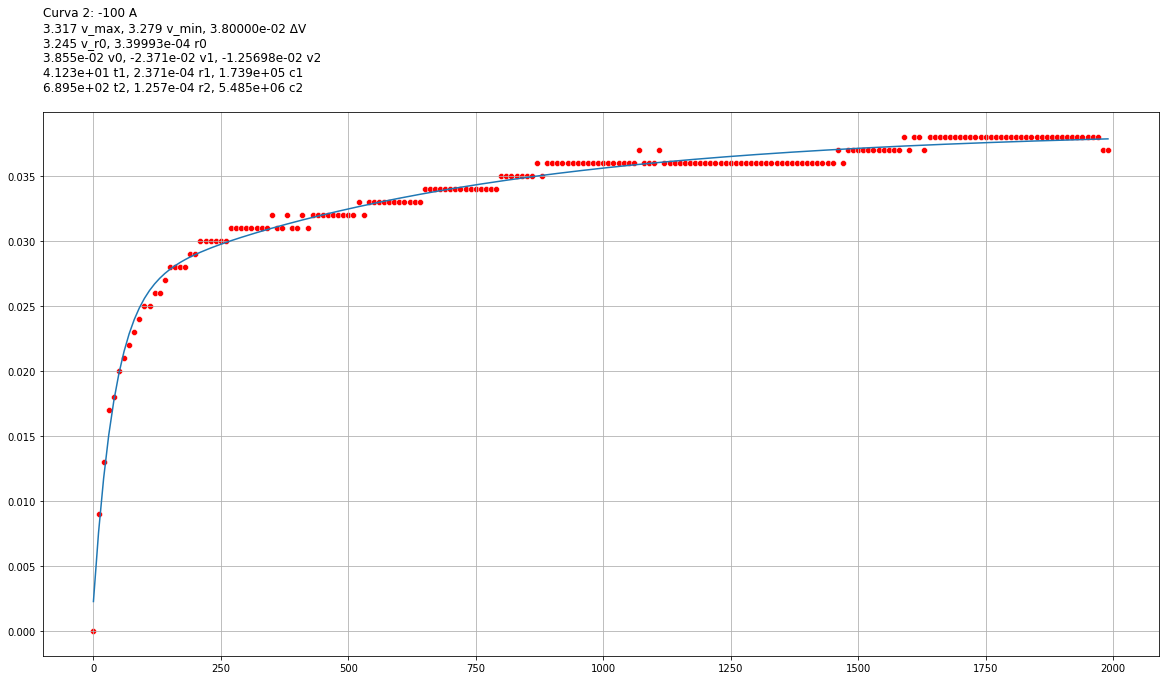

Curva 3: -100 A
3.304 v_max, 3.26 v_min, 4.40000e-02 ΔV
3.225 v_r0, 3.49993e-04 r0
4.619e-02 v0, -2.121e-02 v1, -2.30045e-02 v2
4.029e+01 t1, 2.121e-04 r1, 1.899e+05 c1
9.656e+02 t2, 2.300e-04 r2, 4.197e+06 c2 
                


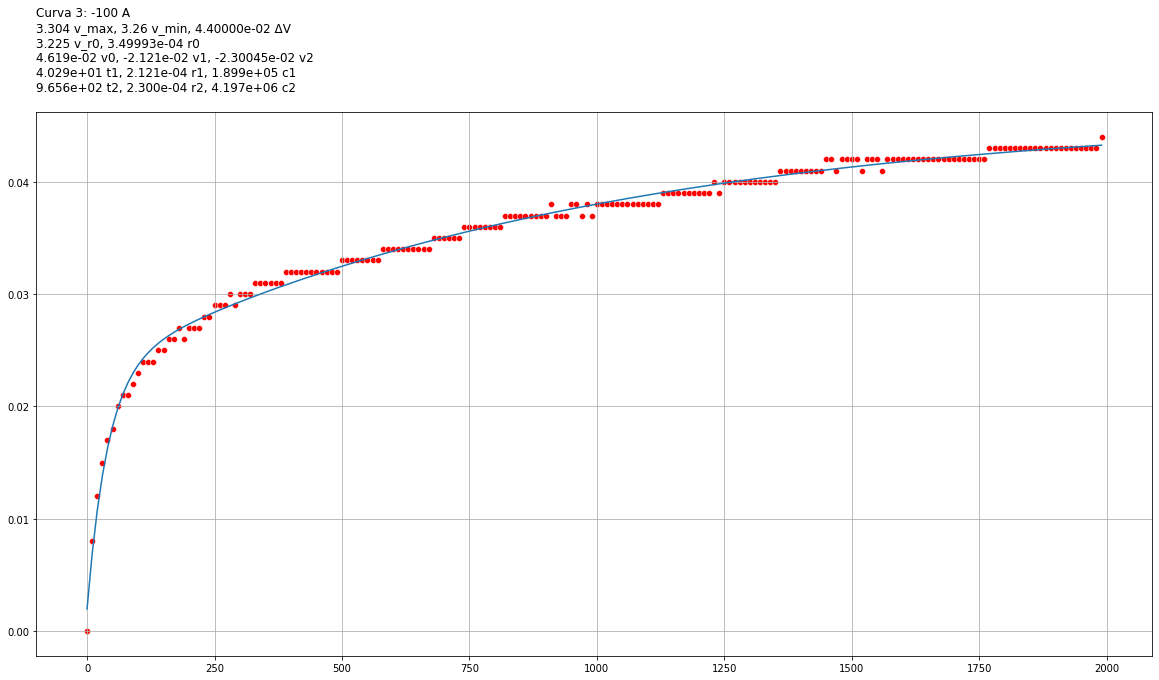

Curva 4: -100 A
3.28 v_max, 3.249 v_min, 3.10000e-02 ΔV
3.215 v_r0, 3.39993e-04 r0
3.082e-02 v0, -2.006e-02 v1, -9.35523e-03 v2
2.870e+01 t1, 2.006e-04 r1, 1.431e+05 c1
6.579e+02 t2, 9.355e-05 r2, 7.032e+06 c2 
                


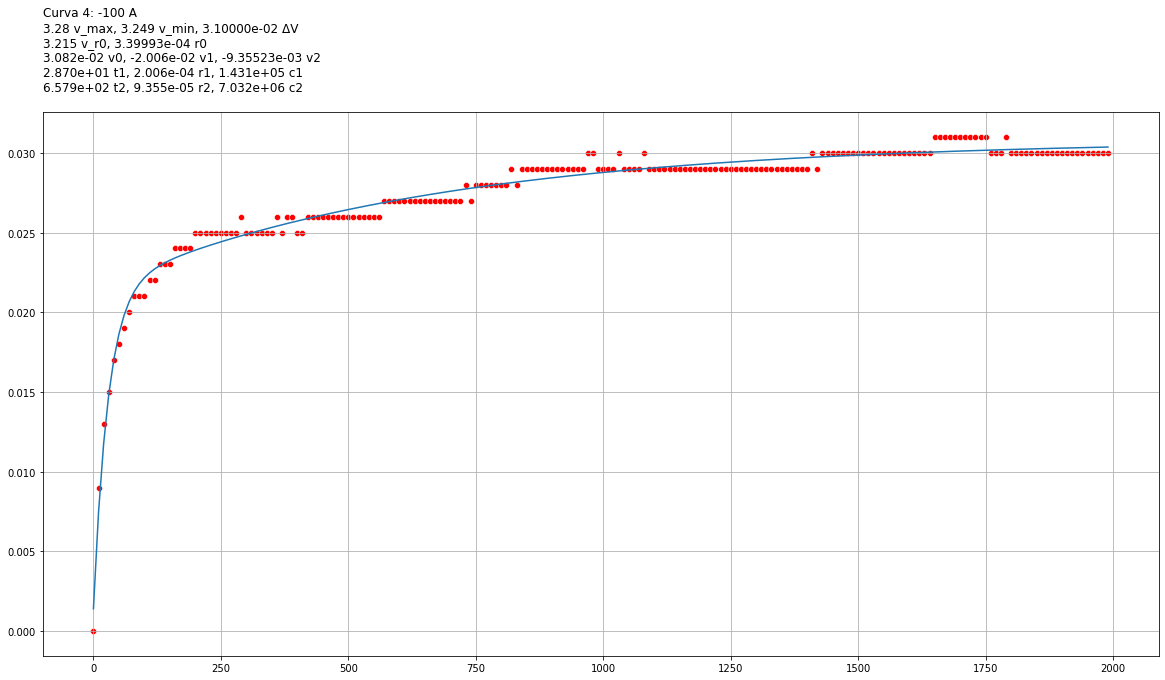

Curva 5: -100 A
3.276 v_max, 3.242 v_min, 3.40000e-02 ΔV
3.207 v_r0, 3.49993e-04 r0
3.400e-02 v0, -2.127e-02 v1, -1.09340e-02 v2
2.984e+01 t1, 2.127e-04 r1, 1.403e+05 c1
5.772e+02 t2, 1.093e-04 r2, 5.279e+06 c2 
                


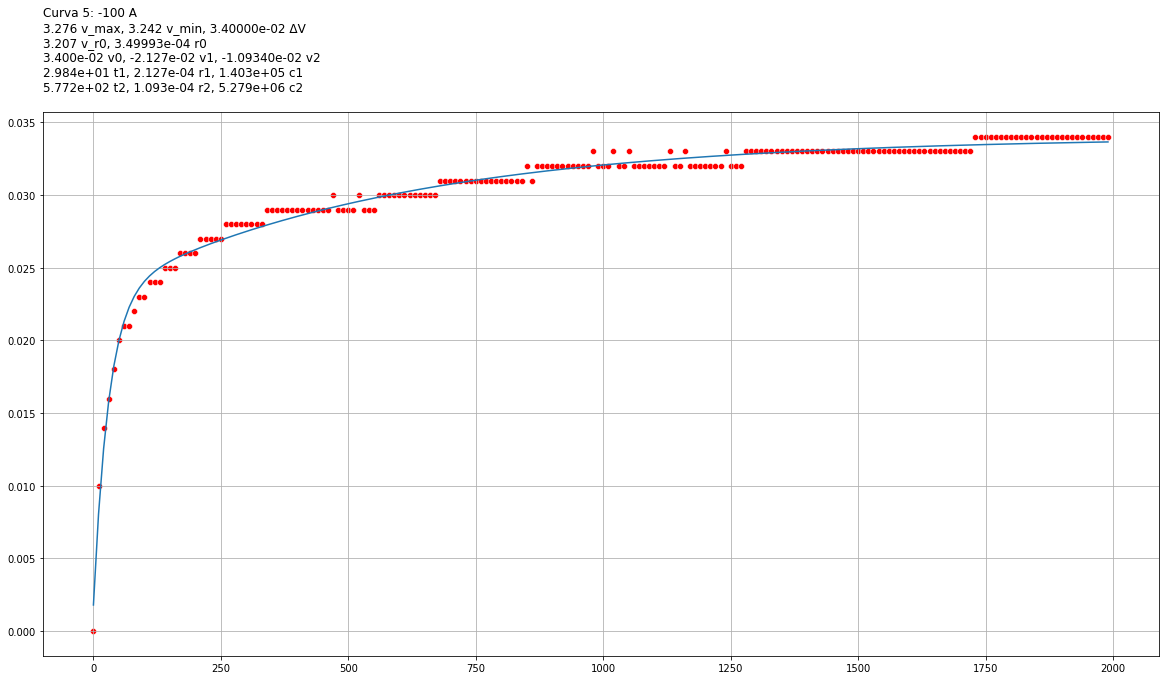

Curva 6: -100 A
3.275 v_max, 3.237 v_min, 3.80000e-02 ΔV
3.2 v_r0, 3.70000e-04 r0
3.870e-02 v0, -2.215e-02 v1, -1.49911e-02 v2
2.917e+01 t1, 2.215e-04 r1, 1.317e+05 c1
7.114e+02 t2, 1.499e-04 r2, 4.745e+06 c2 
                


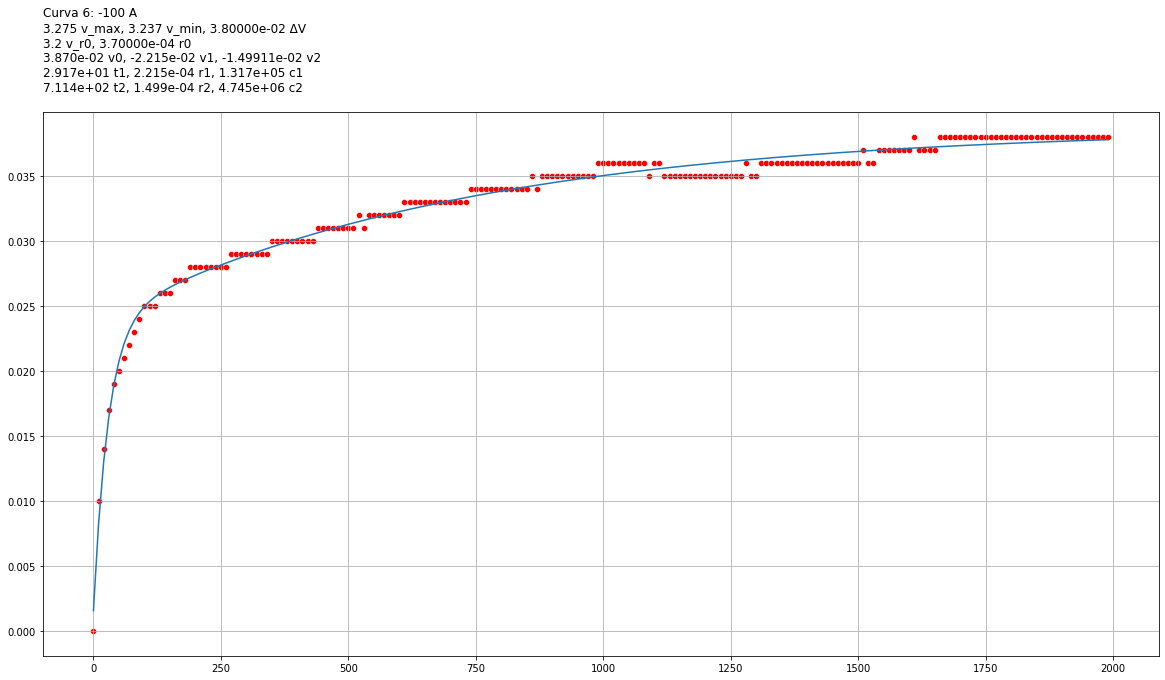

Curva 7: -100 A
3.249 v_max, 3.211 v_min, 3.80000e-02 ΔV
3.174 v_r0, 3.69993e-04 r0
3.749e-02 v0, -2.265e-02 v1, -1.31492e-02 v2
2.699e+01 t1, 2.265e-04 r1, 1.192e+05 c1
6.527e+02 t2, 1.315e-04 r2, 4.964e+06 c2 
                


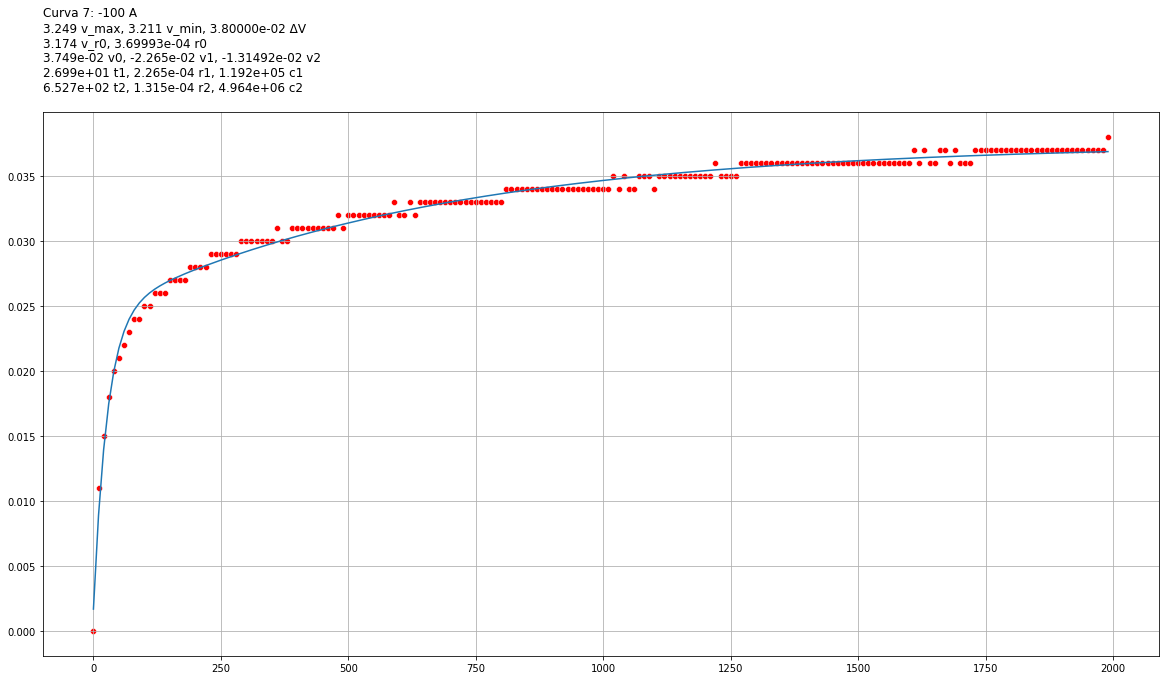

Curva 8: -100 A
3.186 v_max, 3.148 v_min, 3.80000e-02 ΔV
3.11 v_r0, 3.79992e-04 r0
3.732e-02 v0, -2.269e-02 v1, -1.39861e-02 v2
1.505e+01 t1, 2.269e-04 r1, 6.631e+04 c1
2.642e+02 t2, 1.399e-04 r2, 1.889e+06 c2 
                


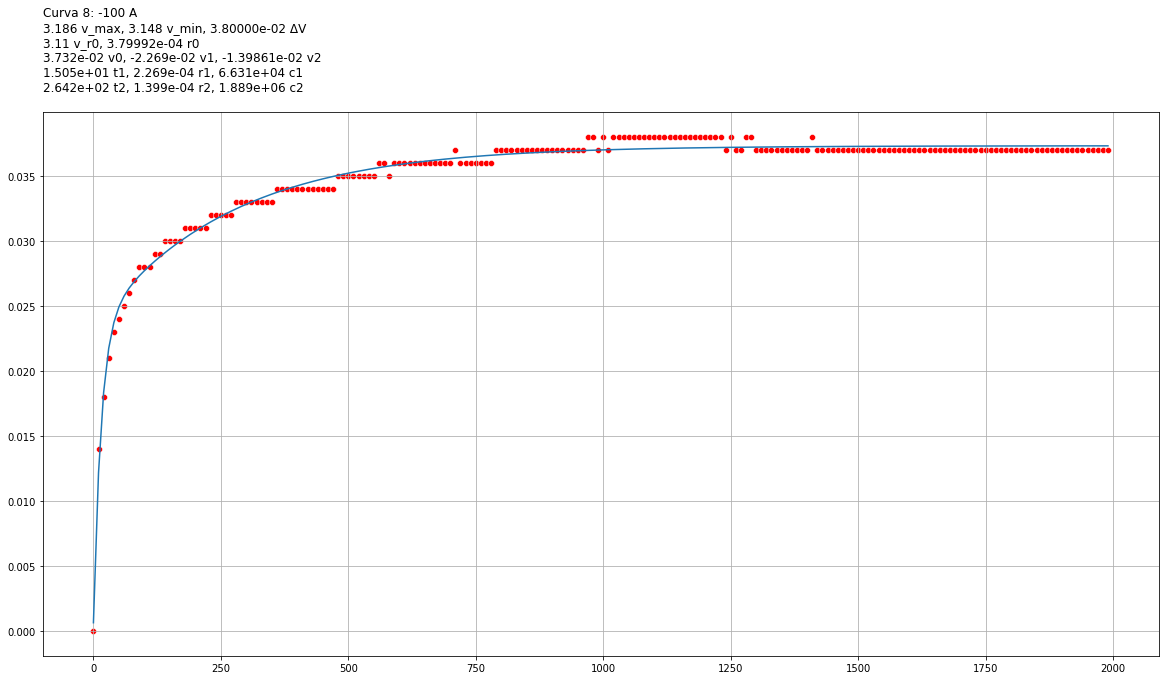

Curva 9: -100 A
3.184 v_max, 3.133 v_min, 5.10000e-02 ΔV
3.092 v_r0, 4.09992e-04 r0
5.047e-02 v0, -3.048e-02 v1, -1.77098e-02 v2
2.306e+01 t1, 3.048e-04 r1, 7.565e+04 c1
5.393e+02 t2, 1.771e-04 r2, 3.045e+06 c2 
                


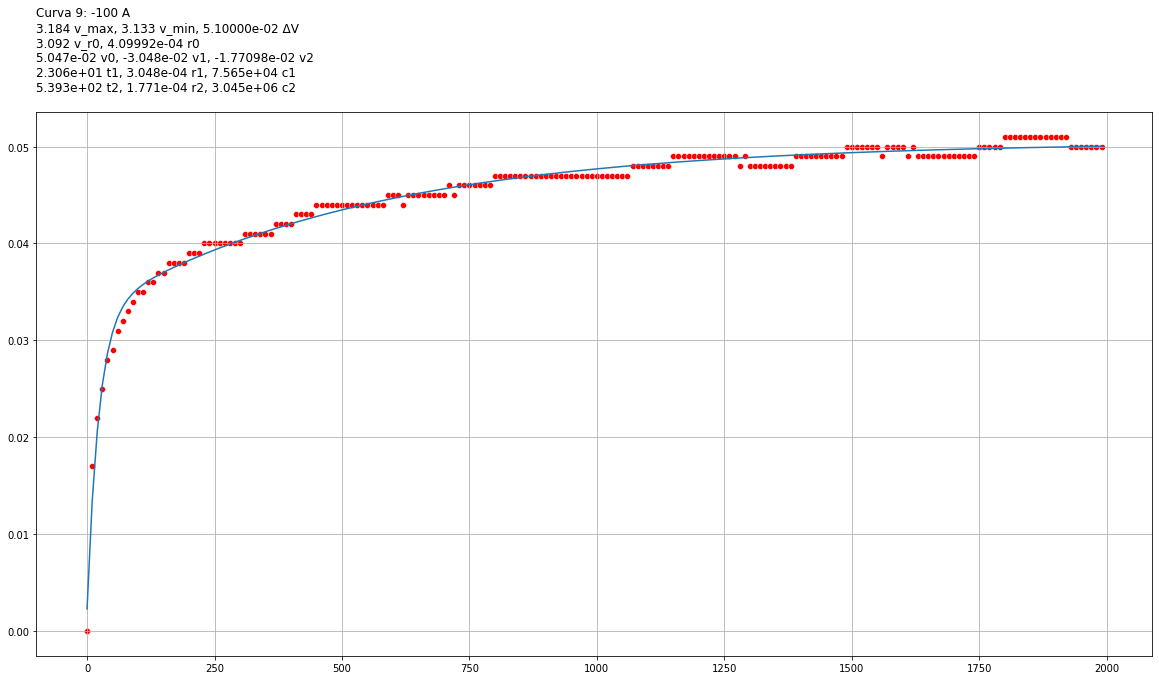

In [6]:
I = '100A'
coeficientes = gerar_coeficientes_e_graficos(points, I ,bounds, coeficientes, p0)

Curva 0: -28 A
3.342 v_max, 3.332 v_min, 1.00000e-02 ΔV
3.324 v_r0, 2.85694e-04 r0
9.547e-03 v0, -5.697e-03 v1, -3.66882e-03 v2
3.089e+01 t1, 2.034e-04 r1, 1.518e+05 c1
5.645e+02 t2, 1.310e-04 r2, 4.308e+06 c2 
                


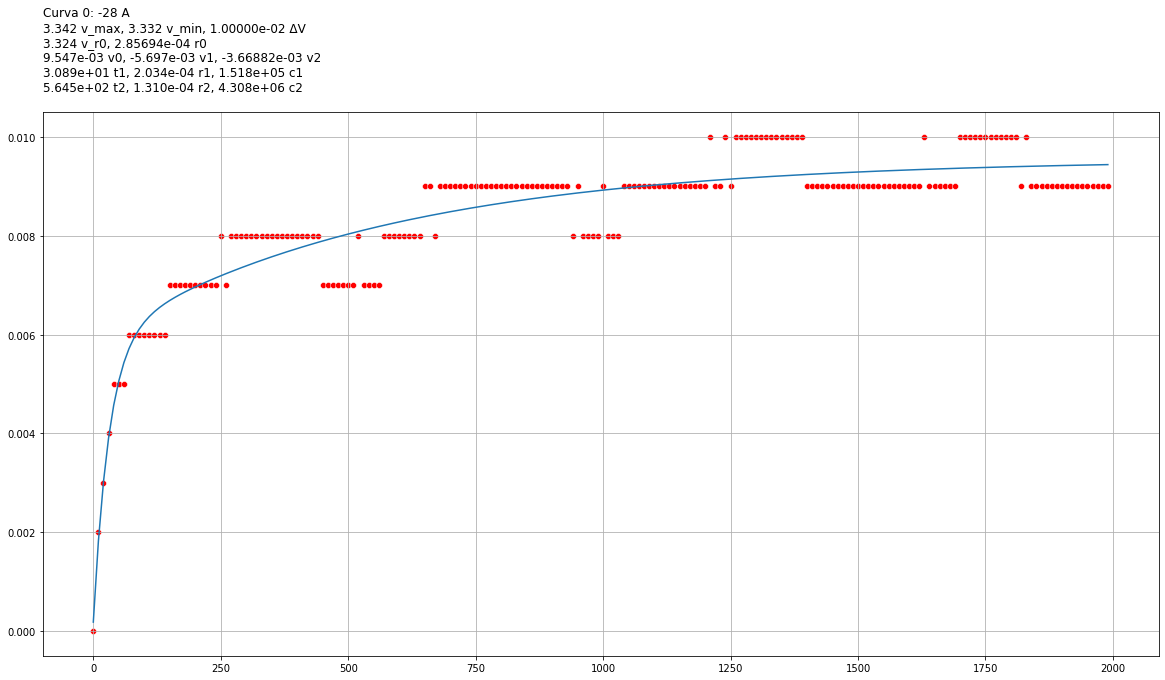

Curva 1: -28 A
3.321 v_max, 3.291 v_min, 3.00000e-02 ΔV
3.291 v_r0, 0.00000e+00 r0
3.037e-02 v0, -1.276e-02 v1, -1.25479e-02 v2
3.851e+01 t1, 4.557e-04 r1, 8.450e+04 c1
6.912e+02 t2, 4.481e-04 r2, 1.543e+06 c2 
                


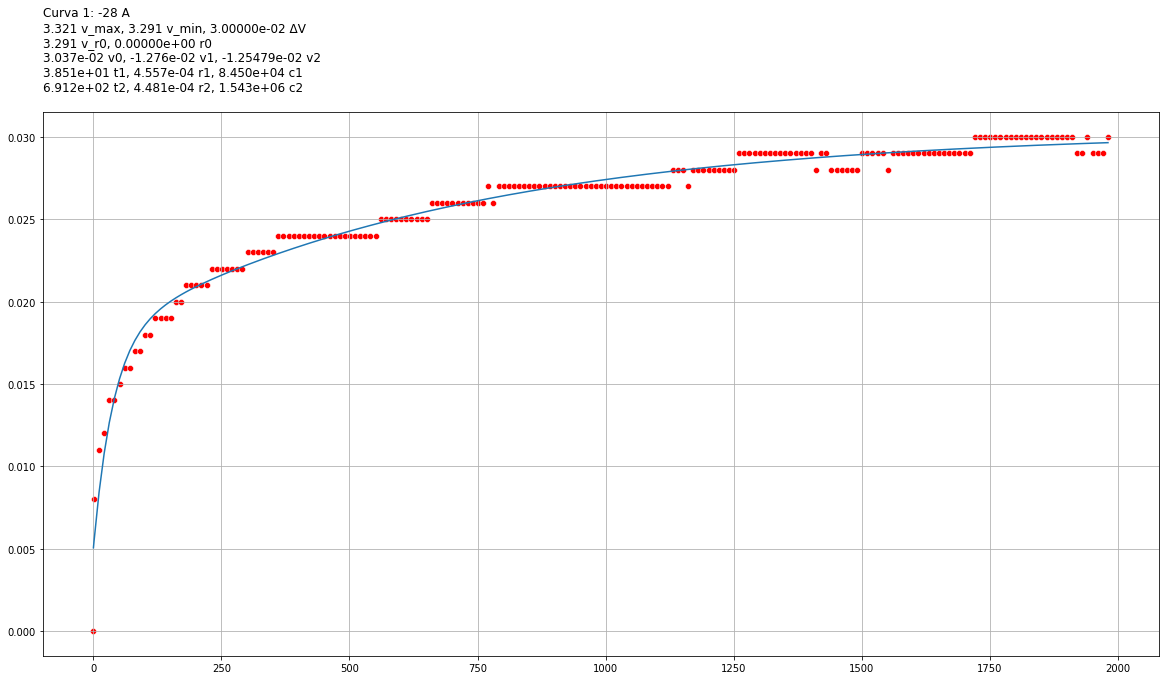

Curva 2: -28 A
3.321 v_max, 3.298 v_min, 2.30000e-02 ΔV
3.289 v_r0, 3.21406e-04 r0
2.271e-02 v0, -1.019e-02 v1, -1.16800e-02 v2
5.571e+01 t1, 3.640e-04 r1, 1.530e+05 c1
5.982e+02 t2, 4.171e-04 r2, 1.434e+06 c2 
                


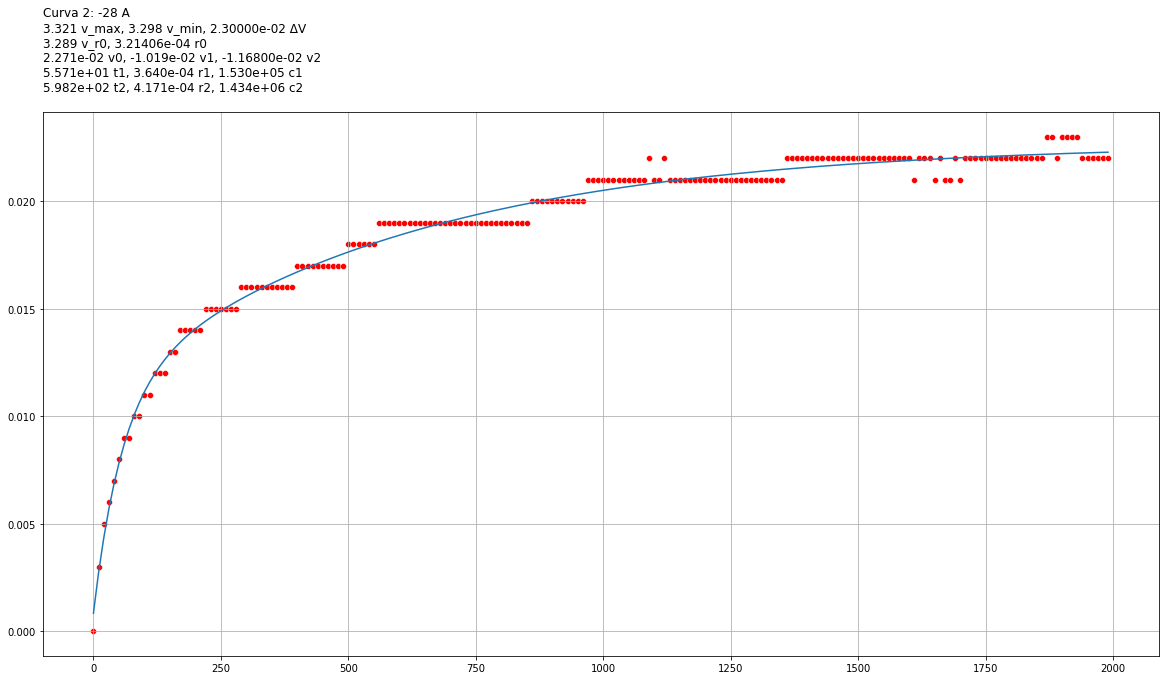

Curva 3: -28 A
3.315 v_max, 3.294 v_min, 2.10000e-02 ΔV
3.285 v_r0, 3.21406e-04 r0
2.191e-02 v0, -1.109e-02 v1, -9.35866e-03 v2
7.966e+01 t1, 3.962e-04 r1, 2.011e+05 c1
8.563e+02 t2, 3.342e-04 r2, 2.562e+06 c2 
                


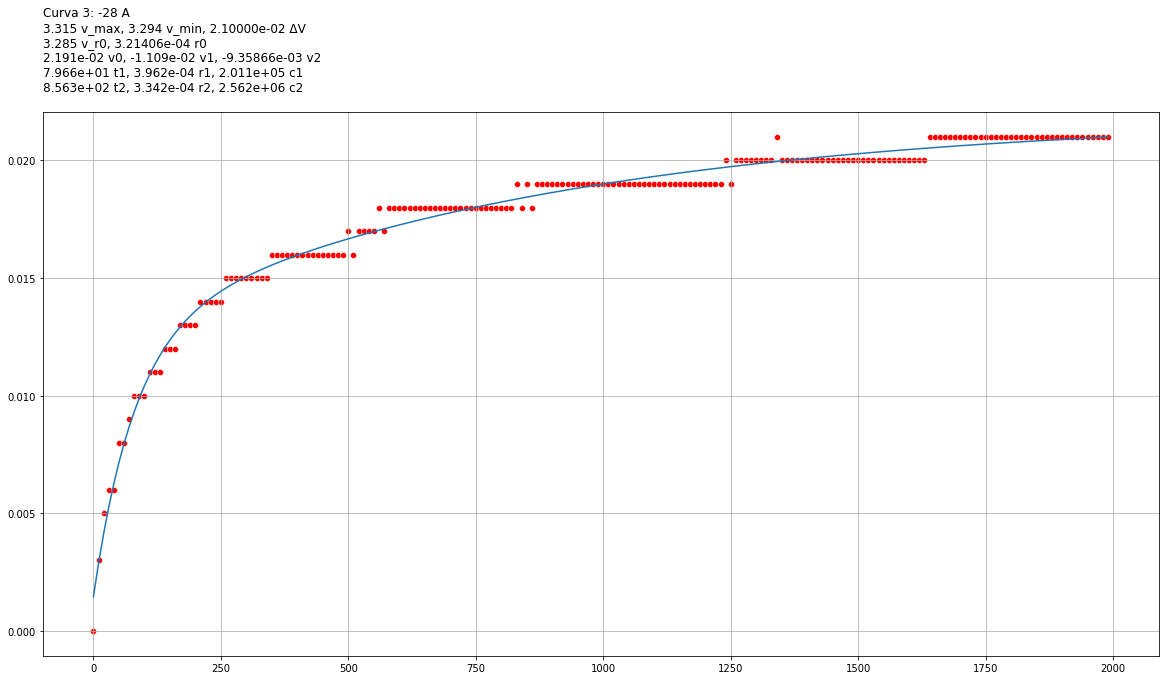

Curva 4: -28 A
3.284 v_max, 3.263 v_min, 2.10000e-02 ΔV
3.254 v_r0, 3.21406e-04 r0
2.151e-02 v0, -1.093e-02 v1, -9.05260e-03 v2
7.288e+01 t1, 3.905e-04 r1, 1.867e+05 c1
6.566e+02 t2, 3.233e-04 r2, 2.031e+06 c2 
                


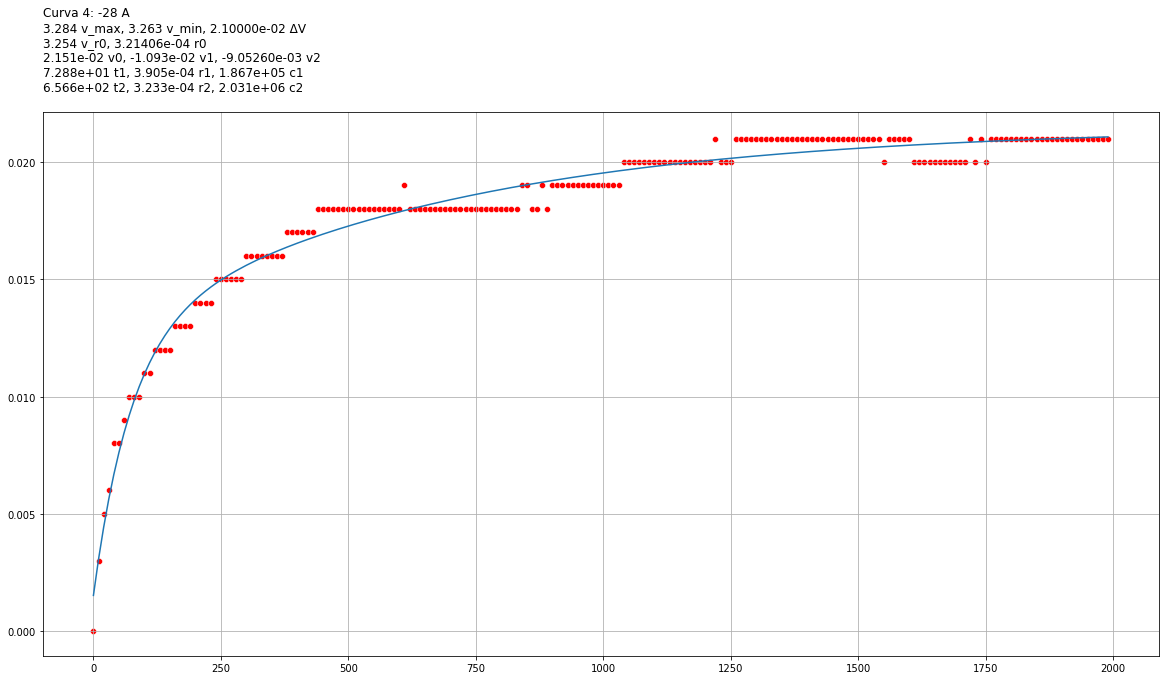

Curva 5: -28 A
3.282 v_max, 3.262 v_min, 2.00000e-02 ΔV
3.253 v_r0, 3.21406e-04 r0
1.941e-02 v0, -7.983e-03 v1, -1.15162e-02 v2
2.222e+01 t1, 2.851e-04 r1, 7.795e+04 c1
3.769e+02 t2, 4.113e-04 r2, 9.164e+05 c2 
                


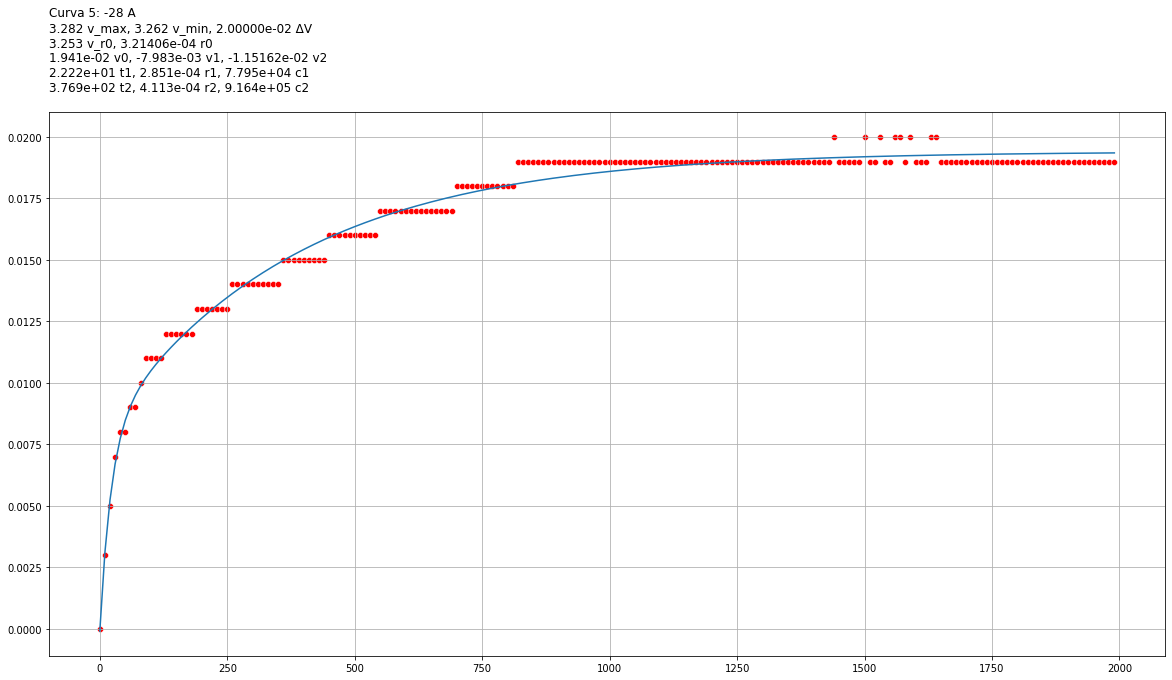

Curva 6: -28 A
3.279 v_max, 3.258 v_min, 2.10000e-02 ΔV
3.25 v_r0, 2.85694e-04 r0
2.121e-02 v0, -1.036e-02 v1, -9.72654e-03 v2
4.523e+01 t1, 3.700e-04 r1, 1.223e+05 c1
5.561e+02 t2, 3.474e-04 r2, 1.601e+06 c2 
                


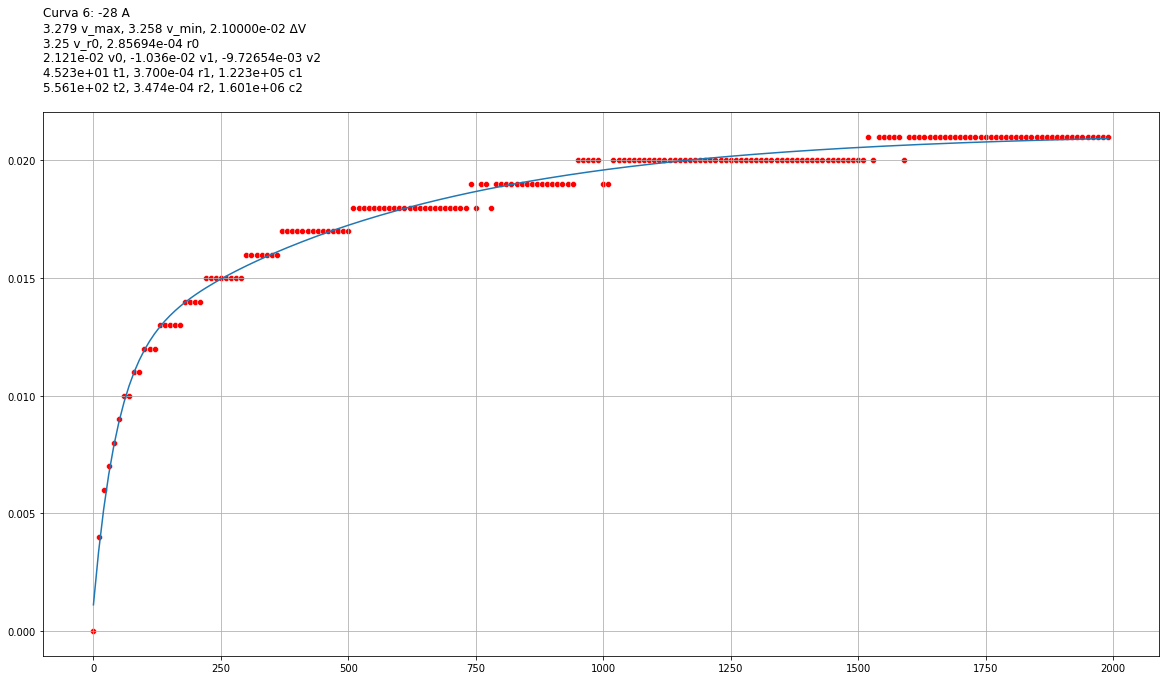

Curva 7: -28 A
3.259 v_max, 3.237 v_min, 2.20000e-02 ΔV
3.228 v_r0, 3.21406e-04 r0
2.077e-02 v0, -9.923e-03 v1, -1.01576e-02 v2
2.776e+01 t1, 3.544e-04 r1, 7.834e+04 c1
3.112e+02 t2, 3.627e-04 r2, 8.578e+05 c2 
                


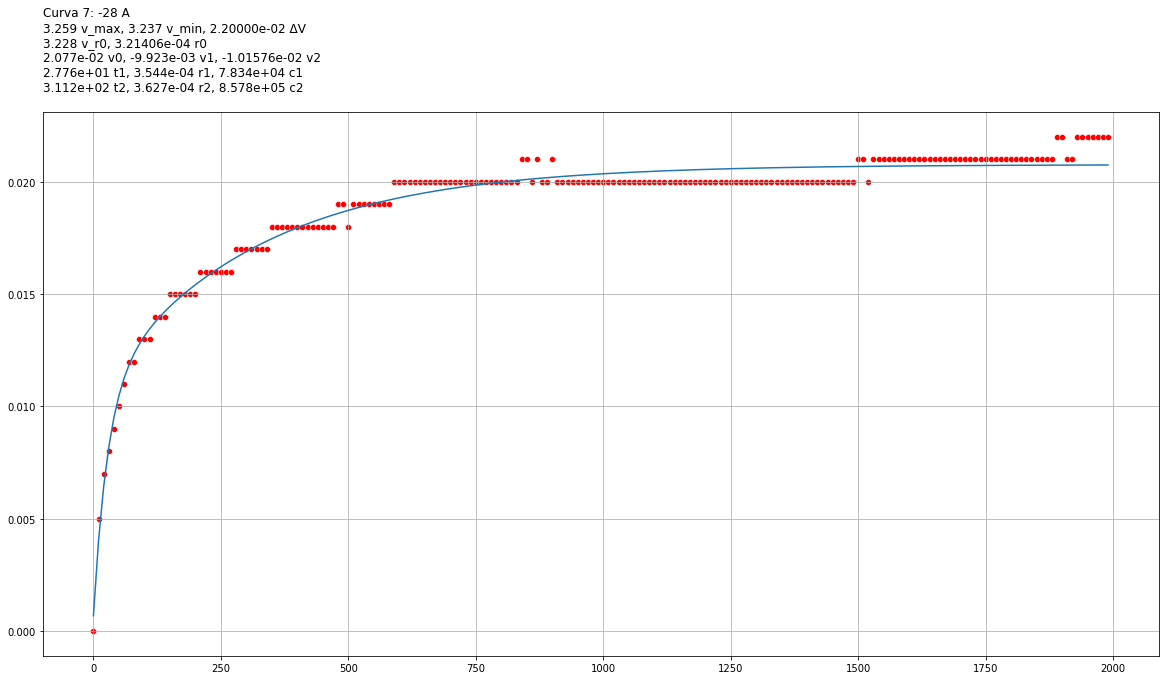

Curva 8: -28 A
3.206 v_max, 3.181 v_min, 2.50000e-02 ΔV
3.171 v_r0, 3.57117e-04 r0
2.363e-02 v0, -1.056e-02 v1, -1.29875e-02 v2
1.938e+01 t1, 3.771e-04 r1, 5.138e+04 c1
2.808e+02 t2, 4.638e-04 r2, 6.053e+05 c2 
                


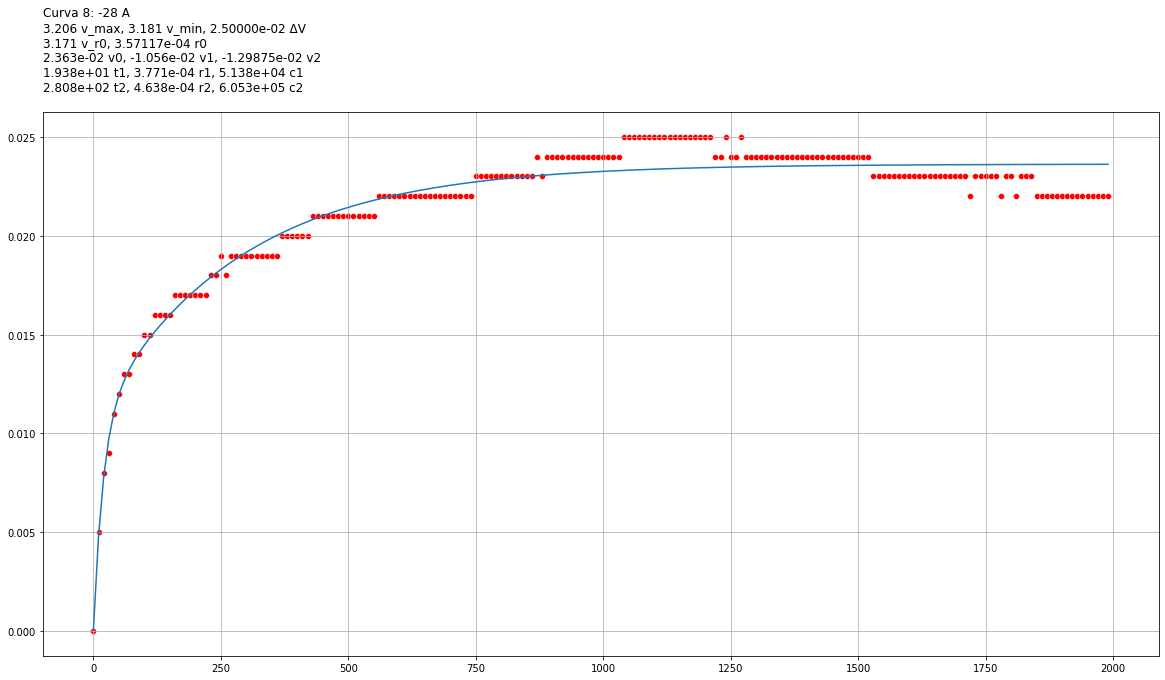

Curva 9: -28 A
3.19 v_max, 3.163 v_min, 2.70000e-02 ΔV
3.153 v_r0, 3.57117e-04 r0
2.774e-02 v0, -1.392e-02 v1, -1.27073e-02 v2
3.192e+01 t1, 4.971e-04 r1, 6.422e+04 c1
8.325e+02 t2, 4.538e-04 r2, 1.834e+06 c2 
                


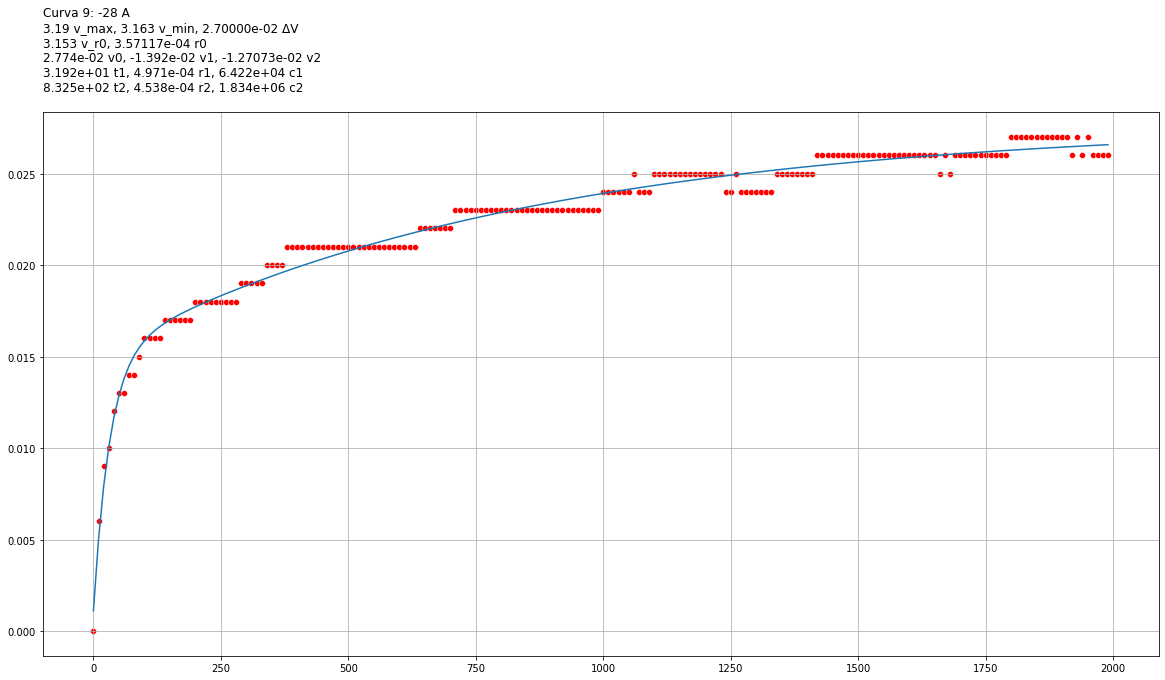

In [7]:
I = '28A'
coeficientes = gerar_coeficientes_e_graficos(points, I ,bounds, coeficientes, p0)

Curva 0: -28 A
3.342 v_max, 3.332 v_min, 1.00000e-02 ΔV
3.324 v_r0, 2.85694e-04 r0
9.547e-03 v0, -5.697e-03 v1, -3.66882e-03 v2
3.089e+01 t1, 2.034e-04 r1, 1.518e+05 c1
5.645e+02 t2, 1.310e-04 r2, 4.308e+06 c2 
                


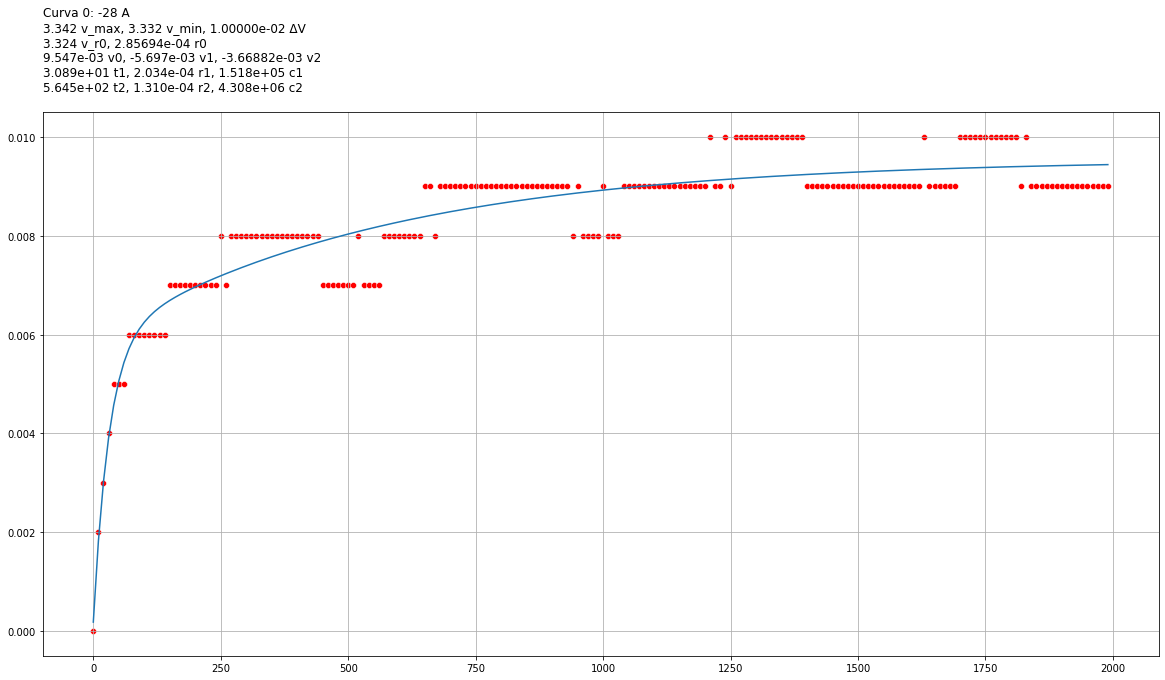

Curva 1: -28 A
3.321 v_max, 3.291 v_min, 3.00000e-02 ΔV
3.291 v_r0, 0.00000e+00 r0
3.037e-02 v0, -1.276e-02 v1, -1.25479e-02 v2
3.851e+01 t1, 4.557e-04 r1, 8.450e+04 c1
6.912e+02 t2, 4.481e-04 r2, 1.543e+06 c2 
                


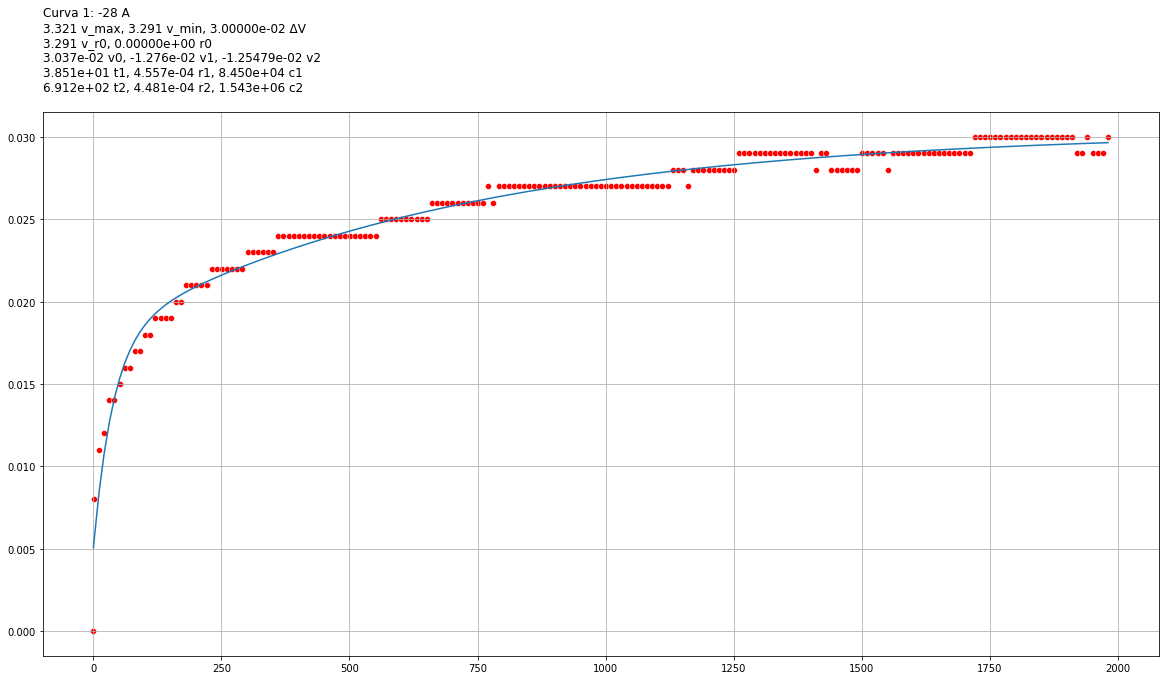

Curva 2: -28 A
3.321 v_max, 3.298 v_min, 2.30000e-02 ΔV
3.289 v_r0, 3.21406e-04 r0
2.271e-02 v0, -1.019e-02 v1, -1.16800e-02 v2
5.570e+01 t1, 3.640e-04 r1, 1.530e+05 c1
5.982e+02 t2, 4.171e-04 r2, 1.434e+06 c2 
                


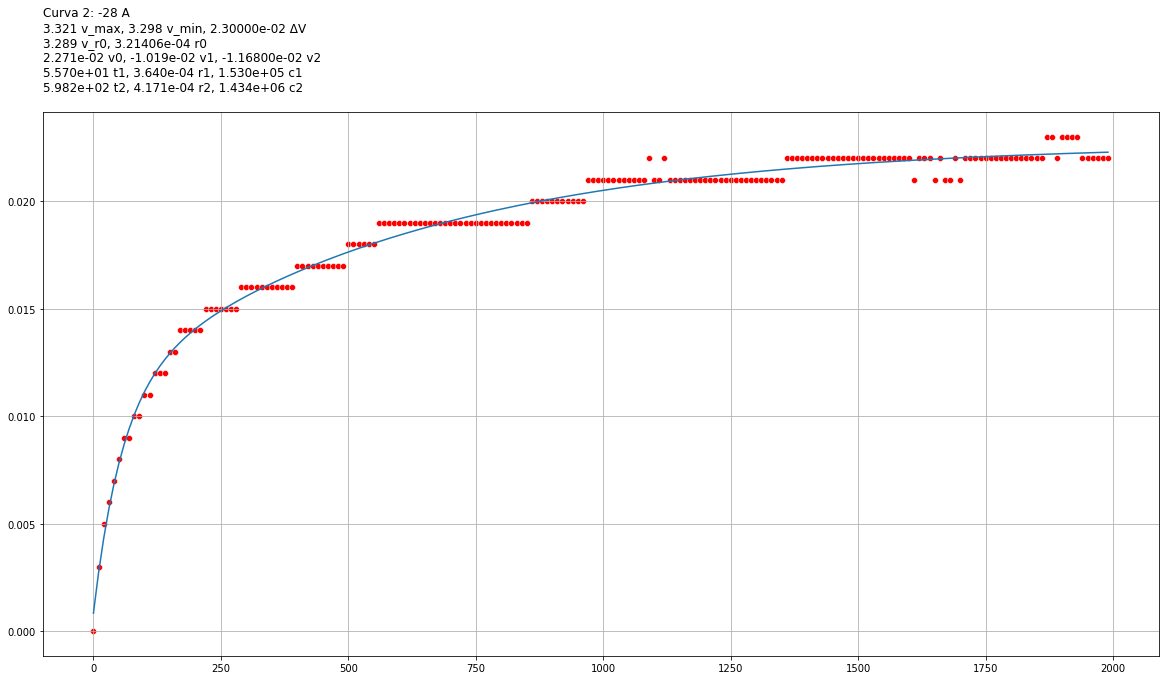

Curva 3: -28 A
3.315 v_max, 3.294 v_min, 2.10000e-02 ΔV
3.285 v_r0, 3.21406e-04 r0
2.191e-02 v0, -1.109e-02 v1, -9.35884e-03 v2
7.966e+01 t1, 3.962e-04 r1, 2.011e+05 c1
8.562e+02 t2, 3.342e-04 r2, 2.562e+06 c2 
                


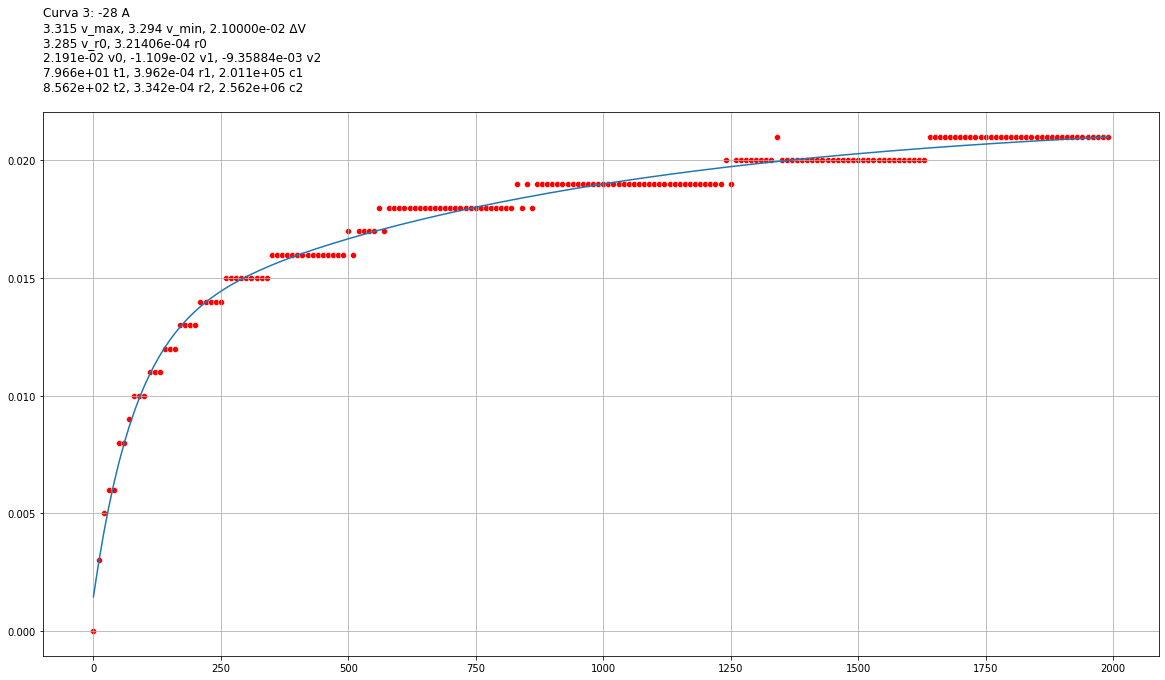

Curva 4: -28 A
3.284 v_max, 3.263 v_min, 2.10000e-02 ΔV
3.254 v_r0, 3.21406e-04 r0
2.151e-02 v0, -1.093e-02 v1, -9.05249e-03 v2
7.288e+01 t1, 3.905e-04 r1, 1.867e+05 c1
6.566e+02 t2, 3.233e-04 r2, 2.031e+06 c2 
                


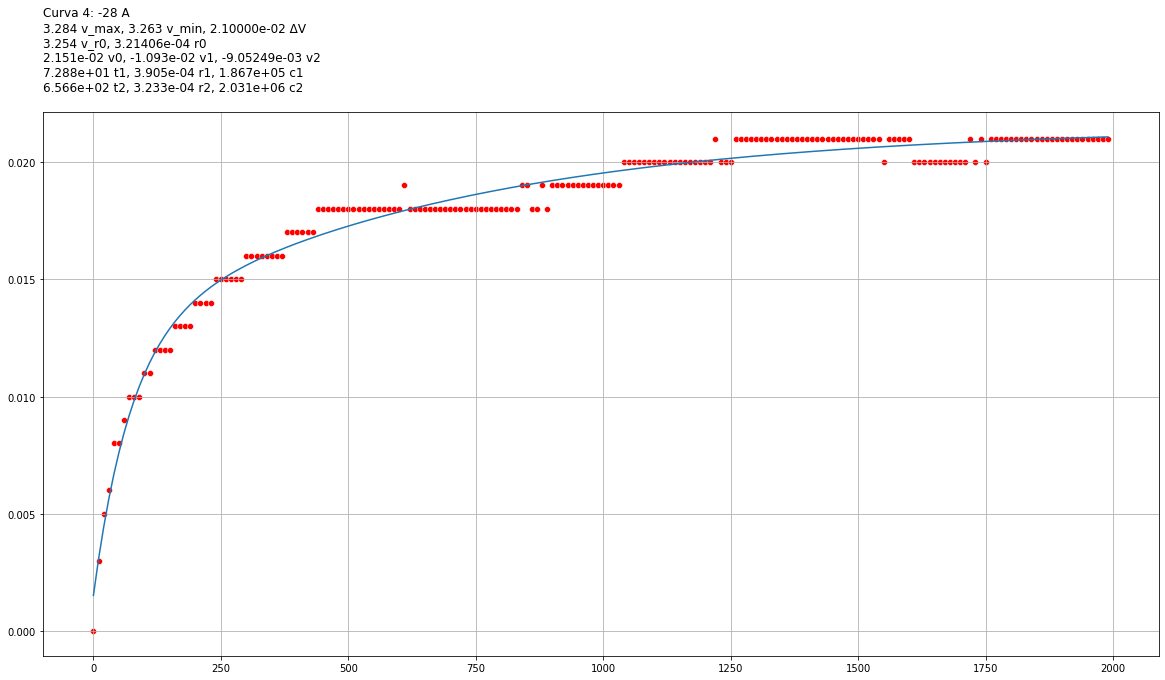

Curva 5: -28 A
3.282 v_max, 3.262 v_min, 2.00000e-02 ΔV
3.253 v_r0, 3.21406e-04 r0
1.941e-02 v0, -7.983e-03 v1, -1.15161e-02 v2
2.222e+01 t1, 2.851e-04 r1, 7.795e+04 c1
3.769e+02 t2, 4.113e-04 r2, 9.164e+05 c2 
                


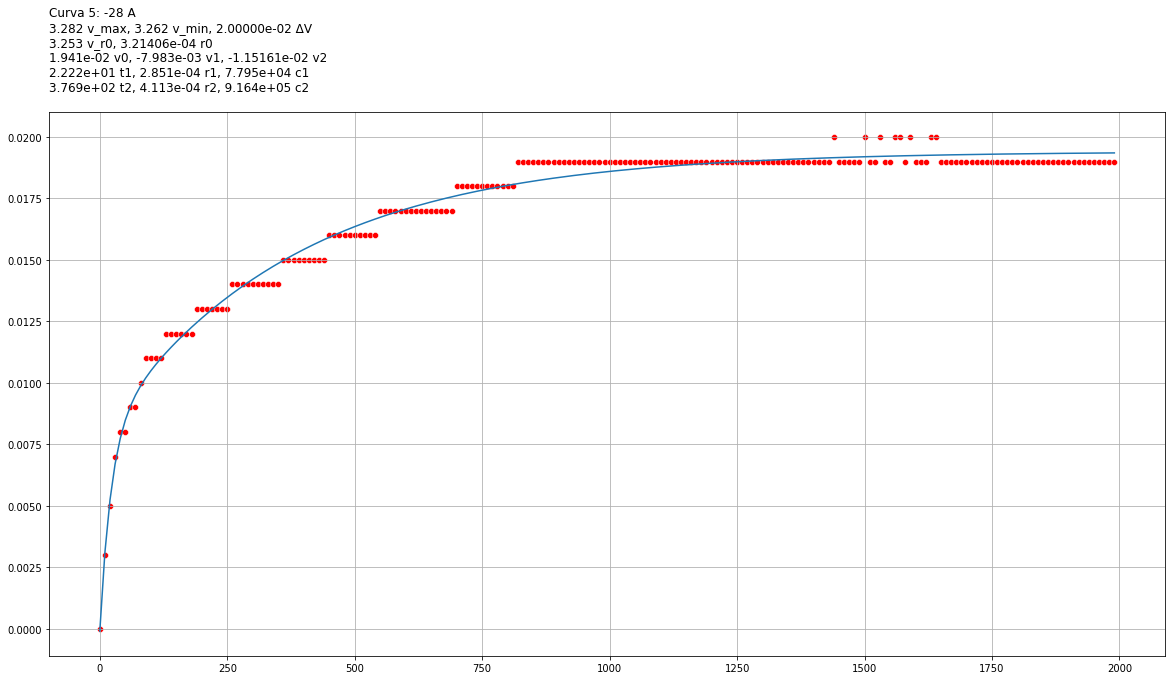

Curva 6: -28 A
3.279 v_max, 3.258 v_min, 2.10000e-02 ΔV
3.25 v_r0, 2.85694e-04 r0
2.121e-02 v0, -1.036e-02 v1, -9.72629e-03 v2
4.524e+01 t1, 3.700e-04 r1, 1.223e+05 c1
5.561e+02 t2, 3.473e-04 r2, 1.601e+06 c2 
                


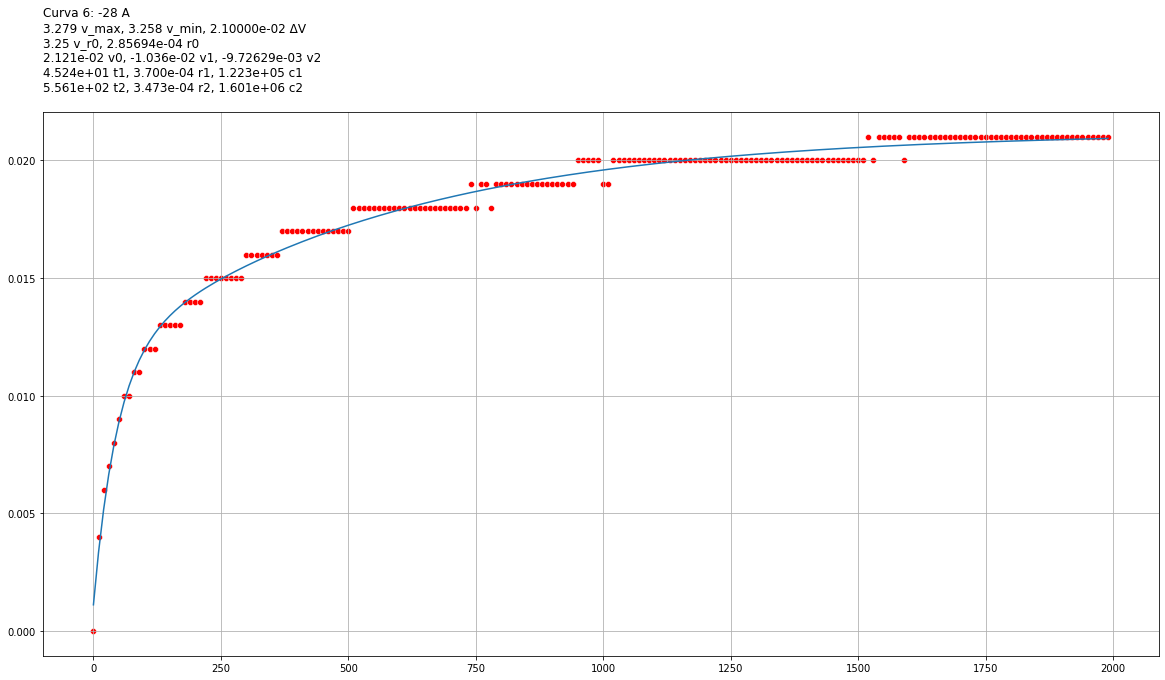

Curva 7: -28 A
3.259 v_max, 3.237 v_min, 2.20000e-02 ΔV
3.228 v_r0, 3.21406e-04 r0
2.077e-02 v0, -9.923e-03 v1, -1.01576e-02 v2
2.776e+01 t1, 3.544e-04 r1, 7.834e+04 c1
3.112e+02 t2, 3.627e-04 r2, 8.578e+05 c2 
                


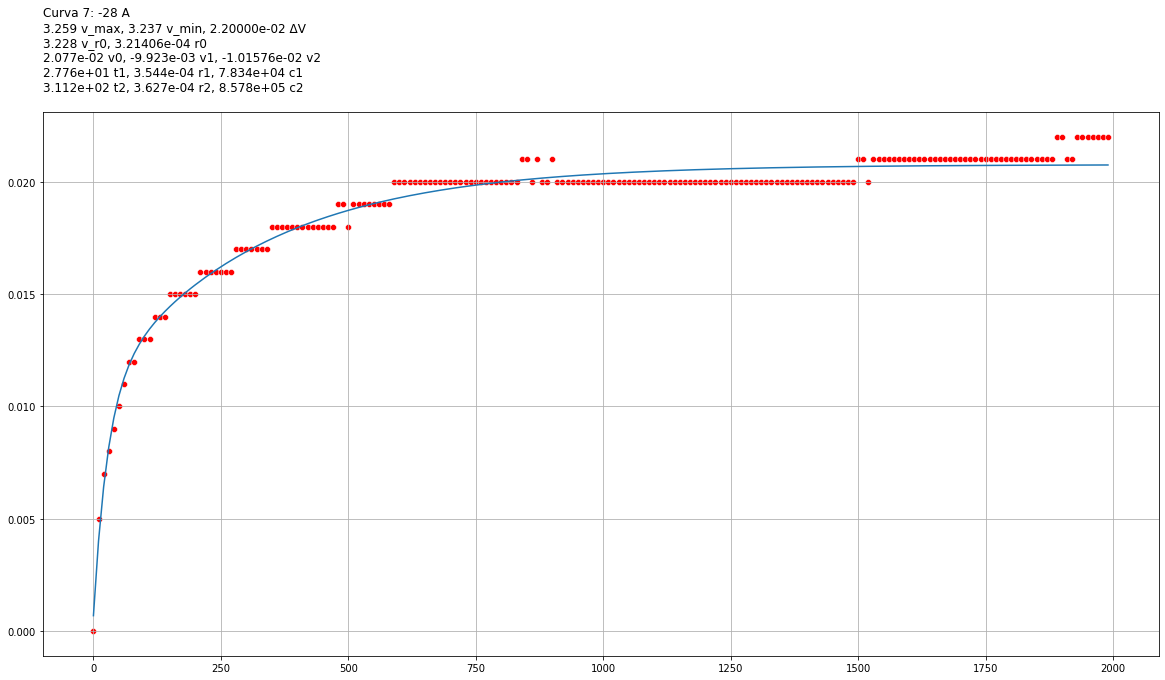

Curva 8: -28 A
3.206 v_max, 3.181 v_min, 2.50000e-02 ΔV
3.171 v_r0, 3.57117e-04 r0
2.363e-02 v0, -1.056e-02 v1, -1.29876e-02 v2
1.938e+01 t1, 3.771e-04 r1, 5.138e+04 c1
2.808e+02 t2, 4.638e-04 r2, 6.053e+05 c2 
                


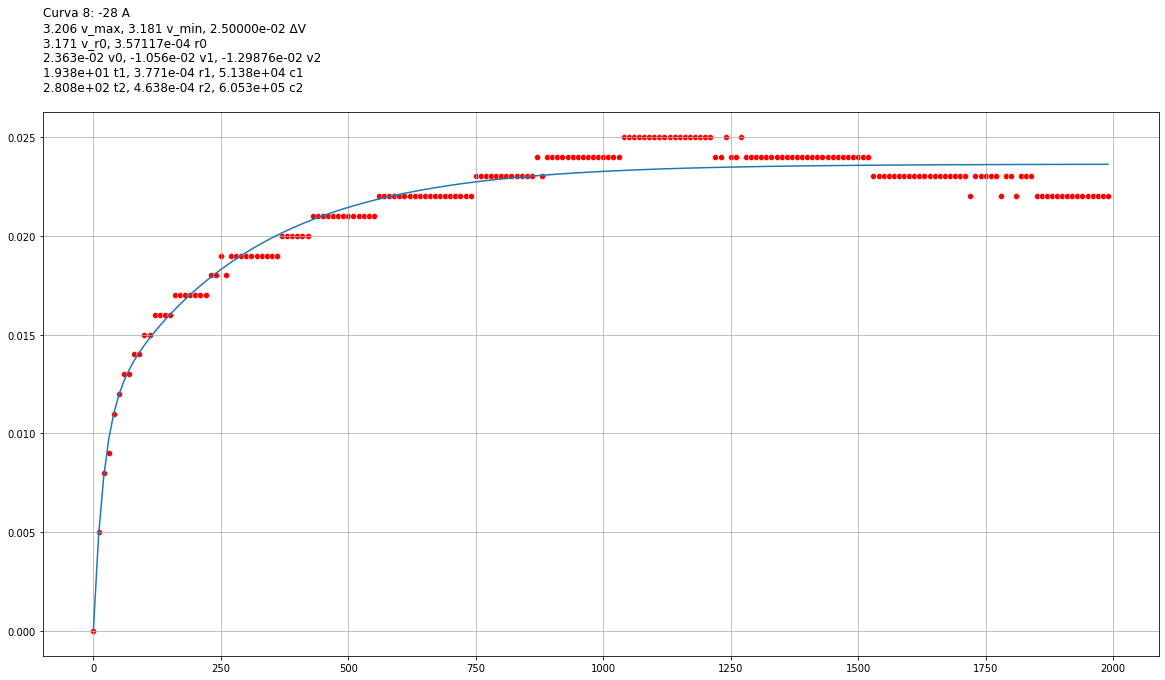

Curva 9: -28 A
3.19 v_max, 3.163 v_min, 2.70000e-02 ΔV
3.153 v_r0, 3.57117e-04 r0
2.774e-02 v0, -1.392e-02 v1, -1.27073e-02 v2
3.192e+01 t1, 4.971e-04 r1, 6.422e+04 c1
8.325e+02 t2, 4.538e-04 r2, 1.834e+06 c2 
                


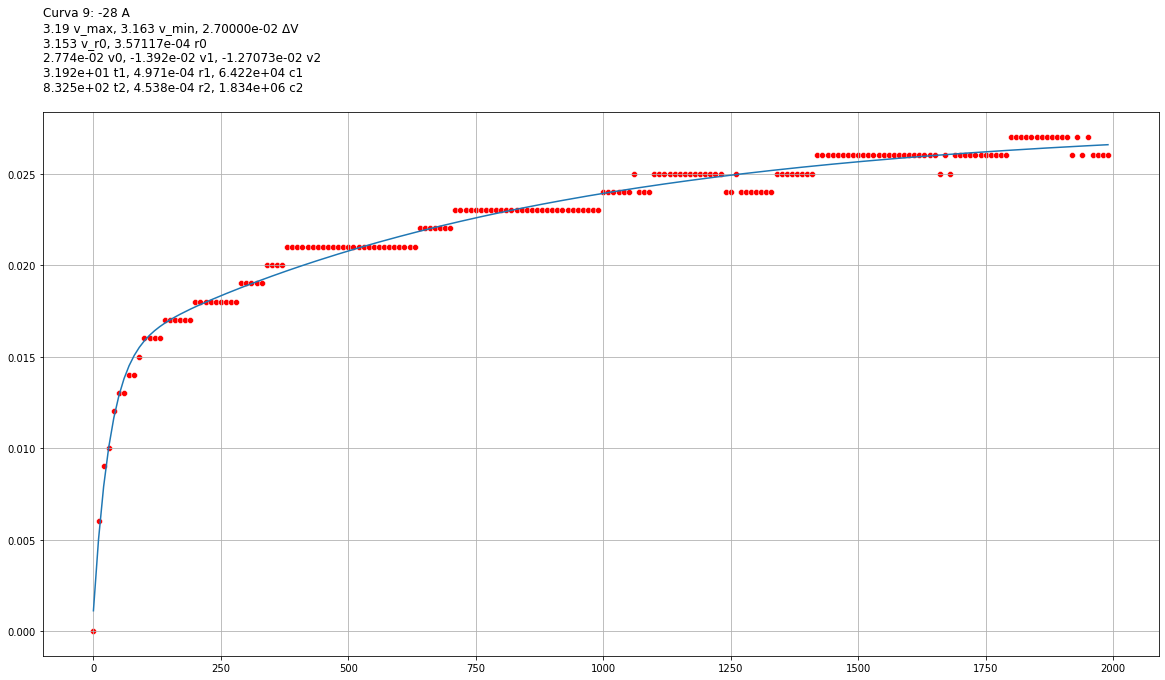

In [8]:
I = '28A'
coeficientes = gerar_coeficientes_e_graficos(points, I ,bounds, coeficientes, p0)